# Modelo Preditivo: Índice de novo cliente

Este notebook apresenta o modelo final, juntamente com toda a exploração de dados, processo de *feature engeneering* e *feature* *importance*.

## Importação das bibliotecas e conjunto de dados

In [2]:
#importamos as libraries necessárias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Autenticação para acesso aos dados
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Download dos dados para esta máquina virtual
downloaded = drive.CreateFile({'id': '1ZOspzswkB75WFfSg23GrCMdqIOf0EXOH'})
downloaded.GetContentFile('data.csv')

In [4]:
# Carregando os dados baixados no dataframe 
df = pd.read_csv('data.csv')

## Entendimento dos dados

Foi realizada uma análise exploratória a fim de compreender a dimensionalidade dos dados, valores nulos etc. 

### Colunas

In [5]:
df.columns # Avaliando as colunas do conjunto de dados

Index(['anomes', 'num_cpf_hash', 'vlr_credito', 'vlr_saldo', 'num_atend_atrs',
       'vlr_score', 'num_produtos', 'num_atend', 'qtd_oper', 'qtd_reclm',
       'qtd_restr', 'vlr_renda', 'cod_rating', 'ind_atrito', 'ind_engaj',
       'ind_novo_cli'],
      dtype='object')

**Ano/Mes** *(anomes)*:

**Número de CPF** *(num_cpf_hash)*: hash de um CPF verdadeiro que não pode ser nulo.

**Valor de crédito no mercado** *(vlr_credito)*:

**Valor do Crédito oferecido pelo banco** *(vlr_saldo)*:

**Valor do Score** *(vlr_score)*:

**Número de atendimentos** *(num_atend)*: quantidade de atendimentos protocolados de um cliente, não necessariamente finalizados ou resolvidos. Esse Campo pode ser nulo.

**Número de atendimentos atrasados** *(num_atend_atrs)*:

**Quantidade de Operações realizadas** *(qtd_oper)*:

**Número de produtos** *(num_produtos)*: número inteiro, que pode ser nulo, que representa os produtos que aquela pessoa tem do banco.

**Quantidade de reclamações abertas** *(qtd_reclm)*:

**Quantidade de restritivos** *(qtd_restr)*:

**Classificação do cliente com o banco** *(cod_rating)*:

**Índice de Atrito** *(ind_atrito)*:

**Índice de Engajamento** *(ind_engaj)*:

**Índice Novo Cliente** *(ind_novo_cli)*: 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12032493 entries, 0 to 12032492
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   anomes          int64  
 1   num_cpf_hash    object 
 2   vlr_credito     float64
 3   vlr_saldo       float64
 4   num_atend_atrs  float64
 5   vlr_score       float64
 6   num_produtos    float64
 7   num_atend       float64
 8   qtd_oper        float64
 9   qtd_reclm       float64
 10  qtd_restr       float64
 11  vlr_renda       object 
 12  cod_rating      object 
 13  ind_atrito      float64
 14  ind_engaj       float64
 15  ind_novo_cli    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 1.4+ GB


In [7]:
df.isnull().sum() # Avaliando valores nulos

anomes                   0
num_cpf_hash             0
vlr_credito        5447936
vlr_saldo          5845720
num_atend_atrs    12026269
vlr_score          3529629
num_produtos       5814374
num_atend         12007828
qtd_oper           5447936
qtd_reclm         12031574
qtd_restr          3919817
vlr_renda         11044566
cod_rating         5845720
ind_atrito        12029266
ind_engaj          9874742
ind_novo_cli      10941418
dtype: int64

In [8]:
# Checagem de quais valores temos na coluna "cod_rating"
df["cod_rating"].unique()

array([nan, 'A', 'HH', 'H', 'C', 'B', 'E', 'F', 'D', 'G', 'AA'],
      dtype=object)

### Isolando os clientes que já foram novos clientes em determinado momento

In [9]:
df_lista_cpf_ind_novo_cli = df[(df.ind_novo_cli== 1)].drop_duplicates() # Gerando uma lista com os CPFs de clientes, em que, algum momento teve o novo cliente igual a 1

In [10]:
df_lista_cpf_ind_novo_cli

,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
277,202104,ffed447b8af4cf211796dd9786c8ee45f5be9960c65c71...,NaN,NaN,NaN,304.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1.0
750,202104,ffcde23dcc7bd0c8c7d5262bc90e982fd7537b5fb8a76e...,NaN,NaN,NaN,592.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
777,202104,ffcc49007c294dfbc7f4091dc2aa89102c48aa6d959407...,NaN,NaN,NaN,359.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1.0
782,202104,ffcc0bf5deb5ebe8ff6ab926231d081864371b625953dd...,43386.67,NaN,NaN,464.0,1.0,NaN,4.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0
853,202104,ffc783fd76c4965d16dc26adba1ae912e2e9c3dc557d19...,0.00,NaN,NaN,447.0,1.0,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12032470,202204,000111d2002be3b465e5ef1061dd2ee84042ed383ecac1...,NaN,NaN,NaN,341.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
12032478,202204,0000c3ddd483fd28829e626bb1a8e4ad973b67b0d8dec2...,NaN,NaN,NaN,374.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
12032479,202204,0000abc06cd3d69b6ea8fefd5abc7ec19210d06b62be04...,NaN,NaN,NaN,389.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
12032482,202204,0000946f9fc340bd9aced00b8c40bca03f56e9d82b253f...,NaN,NaN,NaN,504.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0


## Feature Engineering

Foram testados e documentados cerca de três maneiras de agregação diferentes. 

1º: A primeira maneira foi realizada uma soma com os valores para as seguintes colunas: qtd_oper, qtd_reclm, num_atend_atrs, num_atend, qtd_restr. As demais colunas foi utilizado a mediana. Contudo, não trouxe um desempenho satisfatório *(Ver seção 4.5 - Predictive Model Document)*

2º: A segunda maneira realizada foi utilizando o anomes 11 (Novembro) como base. Esta foi a maneira utilizada e que será apresentada a seguir, por apresentar o maior valor para a métrica de revocação *(Ver serção 4.5)*

3º: A terceira maneira de agregação foi similar a primeira, no entanto, invés de utilizar a soma foi utilizada a mediana dos 12 meses. Também não apresentou um desempenhou satisfatório. 

In [11]:
def treating_data(df,answer,tudo):

  #criamos o dicionário para fazer um label enconding com a data. Se em algum momento decidirmos treinar o modelo com a data poderemos usar as datas transformadas
  dates = {
      202104: 1,
      202105:2,
      202106:3,
      202107:4,
      202108:5,
      202109:6,
      202110:7,
      202111:8,
      202112:9,
      202201:10,
      202202:11,
      202203:12,
      202204:13,
      1:1,
      2:2,
      3:3,
      4:4,
      5:5,
      6:6,
      7:7,
      8:8,
      9:9,
      10:10,
      11:11,
      12:12,
      13:13
  }

  #aplicamos o dicionário a coluna
  df["anomes"] = df["anomes"].apply(lambda x: dates[x])
 

  #retirar valores Nan do cod rating substituindo pelo valor mais comum que é A
  df["cod_rating"].fillna("A", inplace=True)
  if not tudo:
    temp = df[df["anomes"]==11]
  else:
    temp = df
    media =  df[df["anomes"]==11]

  # fazemos um label enconding, já que um hot encode quando tentamos tornou o dataframe muito pesado, devido aos múltiplos valores de cod_rating
  cod_ratings = {
    "HH": 0,
    "H": 1,
    "G":2,
    "F":3,
    "E":4,
    "D":5,
    "C":6,
    "B":7,
    "A":8,
    "AA":9,
    0:0,
    1:1,
    2:2,
    3:3,
    4:4,
    5:5,
    6:6,
    7:7,
    8:8,
    9:9,
    10:10,
    11:11,
    12:12,
    13:13
  }
  
  #aplicamos as mudanças na variável categórica
  temp["cod_rating"] = temp["cod_rating"].apply(lambda x : cod_ratings[x])
 

  #dataframe de clientes do banco no mês selecionado
  clientes = temp
  

  #lista de valores de trocar valores na por 0
  preencher = ["num_atend_atrs","num_atend","qtd_oper","qtd_reclm","qtd_restr",answer,"num_produtos"]
  #troca os valores
  for column in preencher:
    clientes[column].fillna(0, inplace=True)

  
  #lista de valores de trocar valores na pela media
  preencher = ["vlr_credito","vlr_saldo","vlr_score"]
  #troca os valores]
  if not tudo:
    for column in preencher:
      clientes[column].fillna(clientes[column].mean(), inplace=True)
  else:
    for column in preencher:
      clientes[column].fillna(media[column].mean(), inplace=True)
   


  #tiramos outras colunas de resposta
  try:
    respostas = ["ind_engaj","ind_atrito","ind_novo_cli","vlr_renda"]
    respostas.remove(answer)
    clientes.drop(respostas,inplace=True,axis=1)

  except:
    pass  
    

  #dataframe de resposta e de dados
  return clientes


In [12]:
#tratamos os dados do df
clientes = treating_data(df,"ind_novo_cli",False)

## Feature Importance

Para entender as correlações entre as colunas e otimizar o modelo com as colunas que mais impactarem a modelagem. 

In [13]:
from sklearn.ensemble import RandomForestClassifier

Separando em duas variáveis as colunas preditivas (x_fi "X para a feature importance") e a coluna resposta (y_fi "Y para a feature importance") 

In [14]:
x_fi = clientes.drop(columns=["ind_novo_cli", "num_cpf_hash", "anomes"]).copy() 

In [15]:
y_fi = pd.DataFrame(clientes['ind_novo_cli'].copy())

In [16]:
model = RandomForestClassifier()
model.fit(x_fi, y_fi)

RandomForestClassifier()

In [17]:
features_grau_de_importancia = pd.DataFrame(model.feature_importances_, index = x_fi.columns, columns=["importancia"]).sort_values("importancia", ascending=False)

In [18]:
#vemos a importância das features
features_grau_de_importancia

,importancia
qtd_restr,0.337296
vlr_score,0.294130
vlr_saldo,0.115146
num_produtos,0.109866
qtd_oper,0.082081
cod_rating,0.039528
vlr_credito,0.021910
num_atend,0.000032
qtd_reclm,0.000009
num_atend_atrs,0.000002


In [19]:
#retiro colunas com baixa relevância 
tirar = ["num_atend_atrs","qtd_reclm","num_atend","cod_rating"]
clientes =clientes.drop(tirar,axis=1) 

Estabelecendo uma matriz de correlações

In [20]:
# Criando uma matriz de correlação a partir do método .corr() e aplicando um estilo a ela
matriz_correlacao = clientes.corr().style.background_gradient(cmap='coolwarm')
matriz_correlacao

,anomes,vlr_credito,vlr_saldo,vlr_score,num_produtos,qtd_oper,qtd_restr,ind_novo_cli
anomes,nan,nan,nan,nan,nan,nan,nan,nan
vlr_credito,nan,1.000000,0.196624,0.074429,0.022931,0.300554,0.032450,-0.018105
vlr_saldo,nan,0.196624,1.000000,0.029221,0.047260,0.040705,0.008890,-0.000000
vlr_score,nan,0.074429,0.029221,1.000000,0.207870,0.315108,-0.334681,-0.022756
num_produtos,nan,0.022931,0.047260,0.207870,1.000000,0.496579,-0.096777,-0.349458
qtd_oper,nan,0.300554,0.040705,0.315108,0.496579,1.000000,-0.067731,-0.299163
qtd_restr,nan,0.032450,0.008890,-0.334681,-0.096777,-0.067731,1.000000,-0.110103
ind_novo_cli,nan,-0.018105,-0.000000,-0.022756,-0.349458,-0.299163,-0.110103,1.000000


## Modelagem: RandomForestClassifier

Durante todo o projeto, diferentes modelos foram testados e documentados em diferentes arquivos de *Notebook* do Google Colab. Aqui será apresentado o modelo final utilizado, e que apresentou maior valores para **Revocação** (Métrica utilizada para avaliação do modelo - Consultar seção 4.5) 

### Treino e Teste

A seguir, o conjunto de dados será dividido em treino e teste. O intuito é que o modelo seja treinado com os dados selecionados para o treino, cerca de 80% do conjunto de dados, e testado com o o conjunto de dados reservado para teste. 


In [21]:
# Definindo uma nova variável para x a partir da Feature Importance 
# retiramos  'vlr_saldo','qtd_oper' pois modelos treinados com esses valores indicavam se o cliente era novo ou não influenciando o modelo
x = clientes[[ 'vlr_credito', 'vlr_score', 'qtd_restr']].copy() # 
y = pd.DataFrame(clientes['ind_novo_cli']).copy()

In [22]:
# fazemos o train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=69)

### Hiperparametrização

O modelo apresenta parâmetros para otimizar e maximizar os resultados. Para isso, é executado o comando GridSearch, que realiza um teste dos parâmetros especificados.



A priori, criamos uma instância do modelo RandomForest para utilizarmos no GridSearch. 

In [23]:
#instanceamos o modelo
from sklearn.ensemble import RandomForestClassifier

modelo = RandomForestClassifier()

A escolha do RandomForestClassifier, está pautada nos resultados obtidos na comparação de modelos realizada – tendo como base na média dos *cross_validations*, utilizando a métrica F1_Score.

O RandomForestClassifier consiste em um algoritmo de classificação que gera inúmeras Árvores de Decisão. 

### Treinando o modelo

Gerando uma instância do modelo com os resultados obtidos pelo GridSearch, e treinando o modelo com o conjunto de dados de treino. 


In [24]:
#treinamos o modelo
rfc = RandomForestClassifier(bootstrap=True, max_depth=None, min_samples_leaf=8, min_samples_split=2, n_estimators=80, n_jobs=-1, random_state=42)
rfc.fit(x_train, y_train)

RandomForestClassifier(min_samples_leaf=8, n_estimators=80, n_jobs=-1,
                       random_state=42)

Gerando uma variável **y_pred**, que guarda as classificações que o modelo prediz a partir do X de teste.


In [25]:
y_pred = rfc.predict(x_test)

### Avaliando o modelo



In [26]:
from sklearn.metrics import plot_confusion_matrix, recall_score, precision_score, plot_roc_curve, accuracy_score

A seguir estão os valores de **PRECISÃO**, **REVOCAÇÃO** e **F1 SCORE**: 

In [27]:
recall = recall_score(y_test, y_pred) # Revocação: pode ser compreendidada como a divisão entre os verdadeiros positivos sobre tudo que o modelo deveria ter predito como positivo
precision = precision_score(y_test, y_pred) # Precisão: divisão entre os verdadeiros positivos sobre tudo que o modelo predisse como positivo

In [28]:
recall

0.9477497319384472

In [29]:
precision

0.9130859647653349

In [30]:
f1 = 2 * precision * recall / (precision + recall)
f1

0.9300949889084809

A curva ROC é uma maneira gráfica de compreender a relação entre sensibilidade e especifidade do modelo.

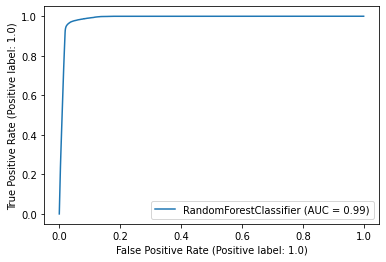

In [31]:
plot_roc_curve(rfc, x_test, y_test) 

A matriz de confusão, é a tabela com duas linhas e duas colunas que relata o número de falsos positivos , falsos negativos , verdadeiros positivos e verdadeiros negativos. 


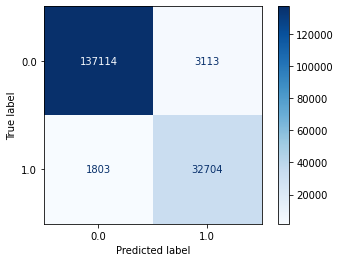

In [32]:
plot_confusion_matrix(rfc, x_test, y_test,cmap="Blues")

In [33]:
print(rfc.score(x_train, y_train))
print(rfc.score(x_test, y_test))

0.9728486523763331
0.9718658074559045


In [34]:
#tratamos os dados do df
clientes = treating_data(df,"ind_novo_cli",True)
# Definindo uma nova variável para X a partir da Feature Importance 
x = clientes[[ 'vlr_credito', 'vlr_score', 'qtd_restr']].copy()
y = pd.DataFrame(clientes['ind_novo_cli']).copy()

In [35]:
x.isna()

,vlr_credito,vlr_score,qtd_restr
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
12032488,False,False,False
12032489,False,False,False
12032490,False,False,False
12032491,False,False,False


In [36]:
#usamos 
y_pred = rfc.predict(x)

In [37]:
recall2 = recall_score(y, y_pred) # Revocação: pode ser compreendidada como a divisão entre os verdadeiros positivos sobre tudo que o modelo deveria ter predito como positivo
precision2 = precision_score(y, y_pred) # Precisão: divisão entre os verdadeiros positivos sobre tudo que o modelo predisse como positivo

In [39]:
print(rfc.score(x, y))

0.9765174182939479


In [ ]:
recall2

In [ ]:
precision2

In [ ]:
plot_confusion_matrix(rfc, x,y,cmap="Blues")

### Deploy

In [ ]:
from joblib import dump

from google.colab import drive
drive.mount('/content/drive')

dump(rfc, '/content/drive/MyDrive/Projeto_Banco_Pan_Grupo_1/Projeto_Banco_Pan_Grupo_1/Projeto_Banco_Pan_Grupo_1/Deploy/Deploy_Ind_novo_cliente.model' )